# ADD TITLE HERE

Example of routine used to extract lead coordinate at 5 km resolution from MODIS imagery.

Resources for active contour model:
 - https://scikit-image.org/docs/dev/api/skimage.segmentation.html

 - https://tirthajyoti.github.io/Scikit-image-book/Active_contour_model.html
 
 Example is for a composite image of the Beaufort and Chukchi Seas sea ice cover on February 20, 2013 from the MODIS imagery files listed below:


In [1]:
with open('MODIS_file_list.txt') as f:
    for line in f:
        print(line.strip())

MOD021KM.A2013051.2250.061.2017294211643.hdf
MOD021KM.A2013051.2255.061.2017294211706.hdf
MOD03.A2013051.2250.061.2017294210914.hdf
MOD03.A2013051.2255.061.2017294210634.hdf


### Import packages

In [2]:
# general
import glob
import os
import sys  
import pandas as pd
import numpy as np

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors

# geospatial
from geopy.distance import geodesic
import cartopy
import cartopy.crs as ccrs

# image analysis
from skimage import io
# from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# import my own functions from within scripts folder 
#********************************************************
sys.path.append('./scripts/')
from LIB_geo_plot_LE import (add_land, add_coast, add_grid)
from LIB_plot_MODIS_LE import get_MODISdate, load_MODISband, get_MODISgeo, pair_images_meta
#********************************************************

# Plotting ice imagery around Point Barrow form level1b MODIS files

### Import imagery from local directory

In [3]:
# set path for location of level1b hdf and geolocation files
#==============================================================
Folder = '/Users/mackenziejewell/Desktop/imagery/'
#==============================================================

# Load metadata of MODIS files from folder and pair images 
# within 'max_diff_minutes' minutes of one another to plot together as a composite
Image_Meta_paired = pair_images_meta(SingleFolder = Folder, max_diff_minutes=20)

Search in single folder: /Users/mackenziejewell/Desktop/imagery/
Pair 0
------
2013-02-20 22:50:00
2013-02-20 22:55:00



### Specify pair of images to plot

In [4]:
# specify pair of images to plot as list
#==============================================================
RunPair = 0
#==============================================================

# grab metadata from current_set of paired images
#------------------------------------------------
current_set = Image_Meta_paired[np.where(Image_Meta_paired[:,4]==RunPair)[0]]

# start empty lists to fill with image names, paths, and dates
IMG_file=[]
GEO_file=[]

# add data from all images in current_set to above lists
counter = 0
for image_meta in current_set:
    # grab date and ImageName for saving from first file in current_set
    if counter == 0:
        ImageDate = image_meta[0]
        ImageName = image_meta[2][0:22]
    IMG_file = np.append(IMG_file, image_meta[3]+image_meta[2])
    GEO_file = np.append(GEO_file, image_meta[3]+image_meta[1])
    counter+=1

# grab imagery data and geo coordinates for image(s)
#---------------------------------------------------
_image_, lat, lon = [], [], []
for ii in range(len(current_set)):
    # import data from modies band 31: TIR 10.780–11.280 micrometers
    _level1bimage_ = load_MODISband(IMG_file[ii], 'EV_1KM_Emissive', '31', 'radiance')
    LAT, LON = get_MODISgeo(GEO_file[ii])   # import geo data
    _image_.append(_level1bimage_)              # add imagery for this file to lists
    lat.append(LAT)                             # add lats to list
    lon.append(LON)           

print('Image is from: {} UTC (day {} of {})'.format(ImageDate,ImageDate.strftime('%j'), ImageDate.strftime('%Y')))

Image is from: 2013-02-20 22:50:00 UTC (day 051 of 2013)


### plot and save image

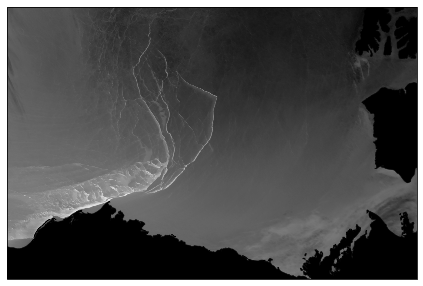

map extent: (-830720.024788084, 830720.024788085, -2366645.164866945, -1263934.2279286042)

>>> save as ./example/MOD021KM.A2013051.2250_base.png


In [5]:
# create figure in NorthPolarStereo projection
#---------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=-145)
lat_range = [68.5, 78]
lon_range = [-125, -165]
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection),figsize=(10,5), facecolor='white')
ax.spines['geo'].set_edgecolor('k')

# set map extent and add geo features
#------------------------------------
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
add_coast(ax, scale='10m', color='k', linewidth=0.5, alpha=1, zorder=10)
add_land(ax, scale='10m', color='k', alpha=1, fill_dateline_gap=True, zorder=9)

# plot imagery
#-------------
for ii in range(len(_image_)):
    ax.pcolormesh(lon[ii], lat[ii], _image_[ii], cmap='Greys_r', vmin=2, vmax=6, shading='gouraud', transform=ccrs.PlateCarree())
plt.show()

# get map extent
#---------------
EXT = ax.get_extent()
print(f'map extent: {EXT}\n')

# save image  
#-----------
SaveName = f'./example/{ImageName}_base.png'
print('>>> save as {}'.format(SaveName)) 
fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)


# Opening plotted sea ice imagery and extracting lead coordinates

### List sea ice imagery files from specified directory

In [6]:
#==================================================================
filepath = './example/'
#==================================================================

# read in list of .png files ending with '_date_nogrid' in filepath
png_list = glob.glob1(filepath, "*_base.png");

# grab dates of imagery files, then sort png list by date 
date_list = [get_MODISdate(png_list[i]) for i in np.arange(len(png_list))]
sorted_png_list = [png_list[i] for i in np.argsort(date_list)]
for ii in range(len(sorted_png_list)):
    print(f'[{ii}] {get_MODISdate(sorted_png_list[ii])} --- {sorted_png_list[ii]}')

[0] 2013-02-20 22:50:00 --- MOD021KM.A2013051.2250_base.png


### Select and plot image

 >>> opening ./example/MOD021KM.A2013051.2250_base.png


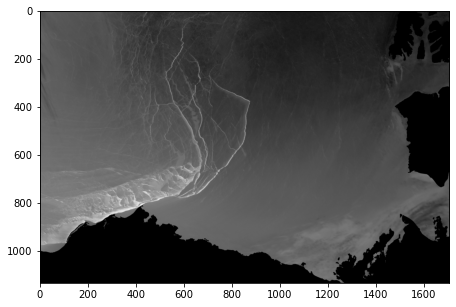

In [7]:
# specify index of image to process
#==================================
image_index = 0
#==================================

# read in image
#--------------
image_path = filepath+sorted_png_list[image_index]
lead_date = date_list[image_index]
print(f' >>> opening {image_path}')
IM = io.imread(image_path)

# plot
#-----
plt.figure(figsize=[10,5])
plt.imshow(IM, 'gray')

### Specify projection used and extent of mapped image

In [8]:
# specify extent of NP stereographic projection plot above
# extent [195, 235, 68.5, 78], central_longitude 215
# ImageCorners = np.array([[196,68],[182,76.5],[248,76.5],[234,68]])
#========================================================
NPS_extent = (-830720.024788086, 830720.024788084, -2366645.1648669443, -1263934.2279286038)
x0, x1, y0, y1 = NPS_extent
#========================================================

-830720.024788086 -2366645.1648669443
830720.024788084 -1263934.2279286038


### click clicky

https://stackoverflow.com/questions/22052532/matplotlib-python-clickable-points
    
https://matplotlib.org/2.0.2/examples/event_handling/lasso_demo.html

selected points:


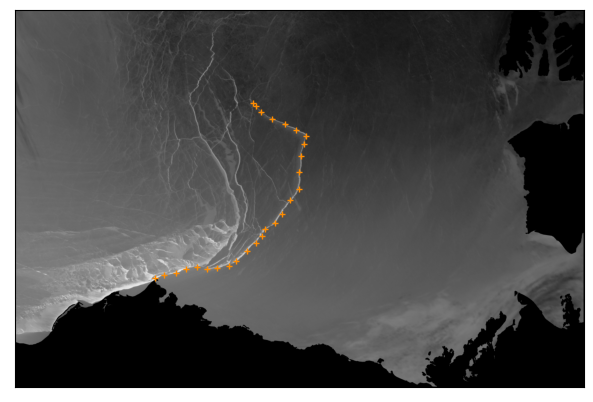

>>> save as ./example/MOD021KM.A2013051.2250_clickpoints.png


In [9]:
# plot in tkAgg window to grab coordinates
matplotlib.use('TkAgg')
# %matplotlib osx
# %matplotlib notebook

# ZOOM IN ON PT. BARROW
#=======================
crop_TOP = 250
crop_RIGHT = 1200
#=======================

# start new figure window
fig = plt.figure(figsize=(15,10), dpi=100)
plt.title("- Click on image to select coordinates\n- Backspace/delete to delete previous click\n- Press enter/return to end")

# make emissive image (convert to grayscale)
grayscale = IM #rgb2gray(rgba2rgb(IM))
plt.imshow(grayscale[crop_TOP:,:crop_RIGHT], cmap = 'gray')
    
# make plot clickable
coords = plt.ginput(-1)


# convert saved coordinates to array
Coords = np.empty(shape=(len(coords),2))
for ii in range(0,len(coords)):
    Coords[ii, 0] = coords[ii][0]
    Coords[ii, 1] = coords[ii][1]+crop_TOP
      
        
# plot image and points afterward
#--------------------------------
%matplotlib inline
print('selected points:')
fig = plt.figure(figsize=([10,5]), dpi=100);
plt.imshow(grayscale, cmap = 'gray');
plt.scatter(Coords[:,0], Coords[:,1], c='darkorange', marker='+', lw=1, s=25)
plt.xticks([]);
plt.yticks([]);
plt.show()

# save image  
#-----------
SaveName = f"{image_path.split('_')[0]}_clickpoints.png"
print('>>> save as {}'.format(SaveName)) 
fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)

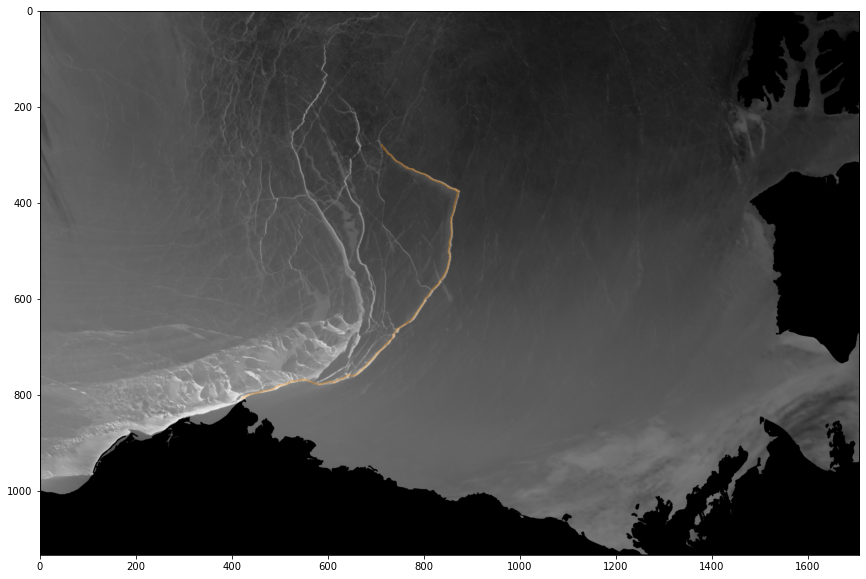

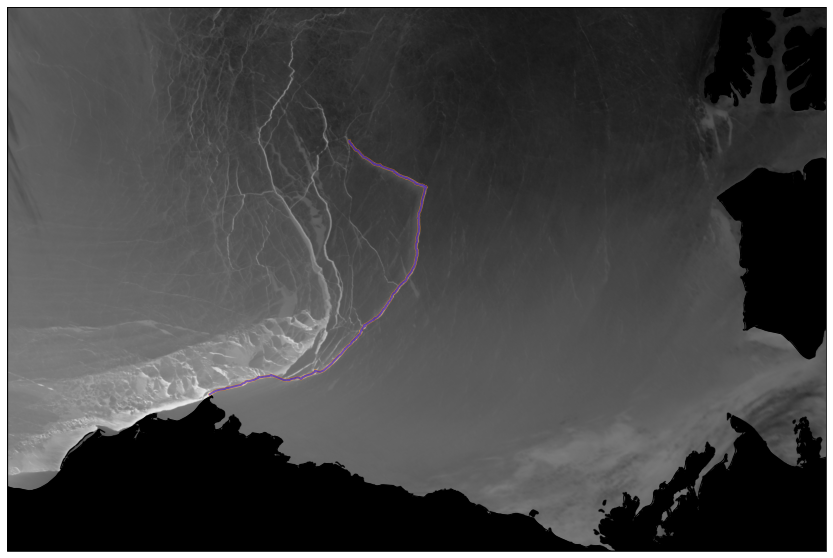

In [10]:
# specify number of steps between each coord
#===========================================
num_steps = 50

max_num_iter = 100
#===========================================

# make array of coords with num_steps between each clicked coord
R = np.array([])
C = np.array([])
for ii in range(len(Coords)-1):
    R = np.append(R,np.linspace(Coords[ii,1], Coords[ii+1,1], num_steps))
    C = np.append(C,np.linspace(Coords[ii,0], Coords[ii+1,0], num_steps))
    
# delete duplicates made when appending coords
R = np.delete(R, np.arange(num_steps, R.size, num_steps))
C = np.delete(C, np.arange(num_steps, C.size, num_steps))

# bind and transpose x,y coordinate arrays
init = np.array([R, C]).T



# start runtime (part 1)
# startTime = datetime.now()

img = grayscale

# gaussian(img, 2)

snake = active_contour(img, init, boundary_condition='free',
                       alpha=0.05, beta=10.0, w_line=3, w_edge=0, gamma=0.1,
                       max_num_iter = max_num_iter)


fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(snake[:, 1], snake[:, 0], c='darkorange', lw=2, alpha=0.3)
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

# record and print runtime
# print('Runtime: ',datetime.now() - startTime)

#===============================
POINTS_TO_CONVERT = snake
#===============================

map_projection = ccrs.NorthPolarStereo(central_longitude=215)

# find percentage of snake coordinates along axes
dir1 = 1-POINTS_TO_CONVERT[:,0]/IM.shape[0]
dir2 = POINTS_TO_CONVERT[:,1]/IM.shape[1]

# find percentage of snake coordinates along axes
dir1_proj = y0+(dir1)*(y1-y0)
dir2_proj = x0+(dir2)*(x1-x0)

# convert coordinates to lon/lat
Points = ccrs.PlateCarree().transform_points(map_projection,dir2_proj,dir1_proj)[:,0:2]
lon = Points[:,0]
lat = Points[:,1]


fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection), figsize=(40,10));

ax.imshow(img, 'gist_gray', origin='upper', extent=NPS_extent, transform=map_projection)
ax.plot(lon, lat,  c='darkorange', alpha=0.5, lw=3, transform = ccrs.PlateCarree())
ax.plot(dir2_proj,dir1_proj, c='b', alpha=0.5, lw=2,  transform = map_projection)
ax.coastlines(resolution='50m', color='black', linewidth=1);

### Save raw lead coordinates

In [11]:
# specify directory to save lead corodinates
#=====================================================
out_path = './example/' #'/Users/mackenziejewell/Desktop/lead_coordinates/'
#=====================================================

# create data frame
df = pd.DataFrame({'latitude': lat,'longitude': lon})

# save data frame
date_string = lead_date.strftime('%Y%j.%H%M')
out_file = out_path+'lead_{}_raw.csv'.format(date_string)
print('>>> save as {}'.format(out_file))
df.to_csv(out_file, index=False)

>>> save as ./example/lead_2013051.2250_raw.csv
